# Sampleo de parámetros del modelo VAR

La finalidad del primer sampleo es encontrar los parámetros para el modelo Vectorial Autoregresivo. Si consideramos una serie de tiempo de dimensión $K$, $y_{1},..., y_{T}$ en donde $y_{t}=(y_{1t}, ..., y_{Kt})$ es un vector de dimensión $K$, entonces el modelo VAR$(p)$ queda definido como (Lutkepohl , 2005):

$$y_{t}=\upsilon + A_{1}y_{t-1}+...+A_{p}y_{t-p}+u_{t} \quad (1)$$

En donde $\upsilon=(\upsilon_{1},...,\upsilon_{K})$ es el vector de interceptos ($K\times1$), $A_{i}$ son los coeficientes matriciales ($K\times K$) y finalmente $u_{t}$ es un ruido blanco de covarianza $\Sigma_{u}$, la cual es de dimensión ($K\times K$). En este caso, asumimos el ruido blanco como una normal multivariada de $K$ dimensiones. Además, definimos la matriz $A=(A_{1}, ..., A_{p})$ en base a los coeficientes matriciales $A_{i}$.

De acuerdo a la definición (1), es posible definir la función de log-likelihood correspondiente (Lutkephol, 2005):

$$ -\frac{KT}{2}ln \, 2\pi - \frac{T}{2} ln \, |\Sigma_{u}| - \frac{1}{2} tr \left[ (Y^0 - AX)' \Sigma_{u}^{-1} (Y^0 - AX) \right] \quad (2)$$
$$Y^0 = (y_{1} - \upsilon , ..., y_{T} - \upsilon)$$
$$X = (Y_0, \ldots, Y_{T-1}) $$
$$ Y_t = (y_{t} - \upsilon, \ldots, y_{t-p+1} - \upsilon)' \quad \forall t = 1,\ldots,T $$

donde $T$ corresponde al numero de observaciones, $tr$ corresponde a la traza de la matriz, y las matrices $Y^0,X$ son obtenidas a partir de las observaciones del proceso $y_{t}$ del modelo VAR. De esta forma, y asumiendo una prior uniforme, es posible definir la distribución posterior de los parámetros $A,\Sigma_u$ en base a (2), a partir de la cual podemos obtener muestras por métodos de Markov Chain Monte Carlo (MCMC).

Para capturar la incertidumbre en los parámetros $A,\Sigma_u$, generamos muestras mediante el método de Gibbs Sampling. En específico, se consideran las distribuciones de probabilidad para la matriz $A$ dadas por:

$$p(A_{ijk}|A_{-i-j-k}, \Sigma_{u}, D), \forall i,j,k. 1\leq i \leq p \wedge 1\leq j, k \leq K$$

en donde $i$ representa a un coeficiente en específico de $A_i$ de acuerdo a la eq. (1). Los indices $j, k$ representan una entrada en específico de la matriz coeficiente $A_i$ de dimensión $K\times K$.

Además, para la matriz de covarianza del ruido blanco $\Sigma_{u}$, se considera la distribución de probabilidad dada por:

$$p({\Sigma_{u}}_{ij}|A, {\Sigma_{u}}_{-i-j}, D), \forall i,j. 1 \leq i, j \leq K $$

en donde $i,j$ representa una entrada en específico de la matriz $\Sigma_{u}$. 

Lo anterior, da lugar a una actualización continua de las matrices $A,\Sigma_{u}$, en donde se fijan todas las entradas de las matrices excepto una, la cual es sampleada según alguna distribución $q$ predefinida. Hasta el momento hemos elegido $q$ ser una normal univariada.

Cabe destacar que para cada sampleo univariado se revisa si es que el nuevo parámetro (en conjunto con los anteriores) cumplen con ciertas restricciones. Para la matriz $A$ se debe cumplir que esta sea estable y $\Sigma_{u}$ debe ser semidefinida positiva (porque se trata de una normal multivariada), por lo tanto, no se acepta el sampleo de un nuevo parámetro hasta que se cumplen estas condiciones.

En la implementación definimos una variable $\theta$ que contiene todos los parámetros correspondientes a las matrices $A$ y $\Sigma_{u}$ en un vector. De esta manera pudimos ir iterando por cada parámetro para ir sampleándolos de manera más simple. 

In [1]:
import utils as ut
import pickle
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
DATA_PATH = '/home/chrisams/Documents/datasets/data_TAIM/processed/'
STATS_PATH = '/home/chrisams/Documents/datasets/data_TAIM/stats.pickle'
#DATA_PATH = 'C:/Users/Samuel/Desktop/2018_01/IIC 3695 Intel Maquina/Tareas y Proyecto/Proyecto/Code/TAIM/data'
POWER_DATA_PATH = '/home/chrisams/Documents/datasets/data_TAIM/data_power.csv'

In [3]:
q = stats.norm(loc=0, scale=1)
K = 3
p = 1
iters = 2
debug = False
n_rows = 10000 # Number of rows of the data to load

In [4]:
samples = ut.gibbs_sampling(iters, DATA_PATH, K, p, q, n_rows=n_rows, debug=debug)

Loading data...
Iteration 0
Iteration 1
Finished!


# Sampleo de velocidades desde el modelo VAR

Un segundo sampleo se hace con la función $\texttt{sim_wind}$. Esta función toma cada una de las muestras de los coeficientes $A$ y de la matriz $\Sigma_{u}$ obtenidas en el proceso anterior y, para cada tiempo $t$ que se quiere predecir (definido en la variable $\texttt{horizon}$) genera velocidades eólicas sampleando desde el ruido blanco cuya matriz de covarianza corresponde a $\Sigma_{u}$. De esta forma, para cada tiempo $t$ se obtiene una distribución de las velocidades en ese instante de cada central eólica. Por mientras, a modo de ilustración, se eligió solo una muestra.

Un ejemplo de esto se puede ver más abajo en los gráficos. Se eligieron los primeros parámetros sampleados por el método anterior y muestrearon 10 velocidades para cada tiempo $t$ que se quería predecir (por temas de visualización). 

In [5]:
x0 = np.transpose(np.matrix([[0.3,0.4,0.7]])) # Initial point of the predictions.
A = samples[0][0]
CovU = samples[0][1]

horizon = 50 # Number of periods (t) to predict ahead.
n_samples = 10 # Number of samples per period.

# Generation of predictions.
time_series = ut.sim_wind(A,CovU,x0,horizon,n_samples)

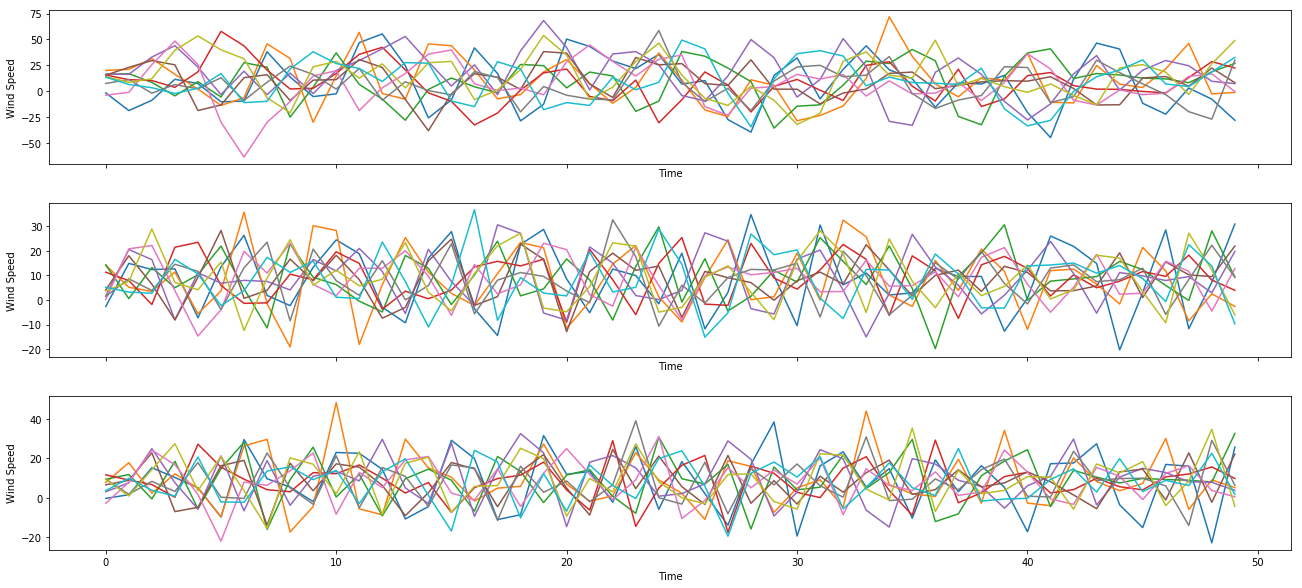

In [6]:
# Adjust time series with their true mean and std.
with open(STATS_PATH, 'rb') as fp:
    stats_dict = pickle.load(fp)

for i in range(K):
    mean = stats_dict['plant_{}'.format(i)]['mean']
    std = stats_dict['plant_{}'.format(i)]['std']
    time_series[i] = time_series[i] * std + mean

#Grafica series de tiempos resultantes
ut.plot_series(time_series)

# Gráfica de la curva de potencia

El siguiente código busca los parámetros de una curva de potencia que se adaptan a los datos de potencia generada según la velocidad del viento (medidos experimentalmente).

In [7]:
data_csv = pd.read_csv(POWER_DATA_PATH) # Speed-PowerGeneration data.
xdata = data_csv['Wind speed (m/s)'].values
ydata = data_csv['Power (kW)'].values

fit_out = curve_fit(ut.PL5, xdata, ydata, maxfev=10000)

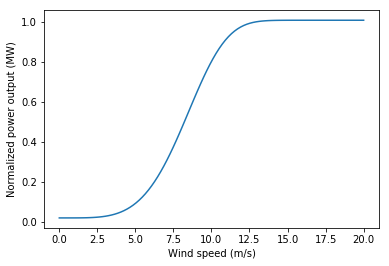

In [8]:
# Plot of the power curve obtained.
u = np.linspace(0.01,20,num=100)
a = fit_out[0][0]
b = fit_out[0][1]
c = fit_out[0][2]
d = fit_out[0][3]
g = fit_out[0][4]
plt_out = ut.PL5(u,a,b,c,d,g)
plt.plot(u,plt_out)
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Normalized power output (MW)')
plt.show()

# Predicción de la potencia generada

El siguiente código busca predecir la potencia generada por las plantas eólicas usando los datos de velocidades generados anteriormente.

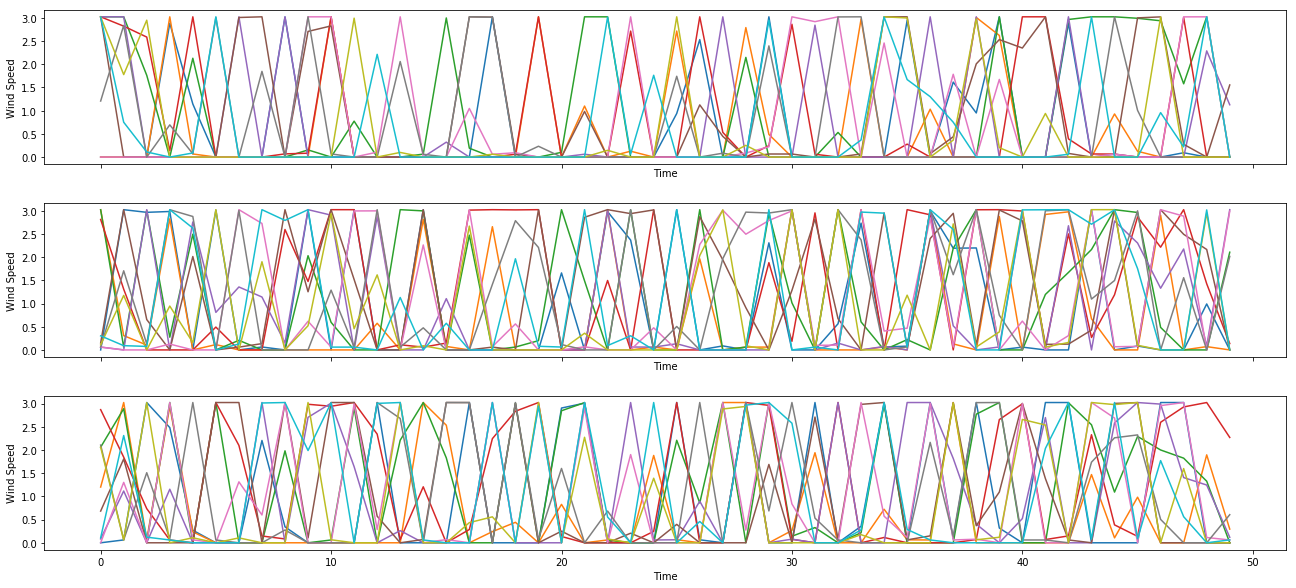

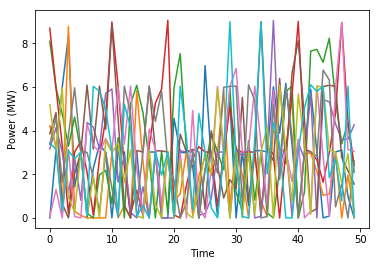

In [9]:
## Apply transformation to simulated wind series: power + sum 

#1) Transform to power output.

cap_wind = 3 # wind plant capacity (eg. 3MW)
cut_speed = 20 # Speed where generator stop working for security.

gen_series = ut.power_curve(time_series, cap_wind, cut_speed, a, b, c, d, g)
ut.plot_series(gen_series)

#2) Add for total wind generation.

sum_series = np.sum(gen_series,axis=0)
for k in range(sum_series.shape[0]): #shape[0] == n_samples
    plt.plot(sum_series[k,:])
    plt.ylabel('Power (MW)')
    plt.xlabel('Time')
plt.show()